In [1]:
import pandas as pd
import snscrape.modules.twitter as sntwitter
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
#nltk.download('stopwords') # Comment out after the first time
#nltk.download('omw-1.4')   # Comment out after the first time
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

import string
import re
import textblob
from textblob import TextBlob

from wordcloud import WordCloud, STOPWORDS
from emot.emo_unicode import UNICODE_EMOJI

lemmatizer = WordNetLemmatizer()

from wordcloud import ImageColorGenerator
from PIL import Image

import warnings
%matplotlib inline
import datetime

In [2]:
# Create query and extraction

query = "((Elon Musk OR Musk OR Elon) AND twitter) since:2022-10-27 until:2022-11-04"
tweets = []
for i, tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
    if i > 40000: # Adjust this as needed to change total number of tweets scraped
        break
    else:
        tweets.append([tweet.date,tweet.id,tweet.url,tweet.user.username,tweet.sourceLabel,tweet.user.location,tweet.content,tweet.likeCount,tweet.retweetCount,tweet.replyCount,tweet.hashtags])
df = pd.DataFrame(tweets, columns = ['Date','ID','url','username','source','location','tweet','num_of_likes','num_of_retweets','num_of_replies','hashtag'])

In [3]:
df.sort_values(by='num_of_likes',ascending=False).head(3)

,Date,ID,url,username,source,location,tweet,num_of_likes,num_of_retweets,num_of_replies,hashtag
32238,2022-11-03 15:57:56+00:00,1588198800727846912,https://twitter.com/PopBase/status/15881988007...,PopBase,Twitter for iPhone,,Twitter employee is seen sleeping on office fl...,107068,5820,1237,None
39206,2022-11-03 14:38:22+00:00,1588178778899054592,https://twitter.com/H1ghSKy1/status/1588178778...,H1ghSKy1,TweetDeck,At the Skycastle,Elon Musk has changed Twitter like button from...,98623,539,1013,None
17633,2022-11-03 19:10:24+00:00,1588247237649657862,https://twitter.com/bennyjohnson/status/158824...,bennyjohnson,Twitter for iPhone,Tampa Florida,LOL — @AOC thinks @ElonMusk is messing with he...,72398,4661,18965,None


In [4]:
# Preprocess Data

stop_words = list(stopwords.words('english'))

emoji = list(UNICODE_EMOJI.keys())

In [5]:
def lowercase(text):
    return text.lower()

def remove_punctuation(text):
    text = lowercase(text)
    # Remove links
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)"," ",text).split())
    # Remove repeating characters
    text = re.sub(f'\@\w+|\#w+|\d+', '', text)
    # Remove punctuation & numbers
    punct = str.maketrans('', '', string.punctuation+string.digits)
    text = text.translate(punct)
    return text

def tokenize_text(text):
    text = remove_punctuation(text)
    tokens = word_tokenize(text)
    filtered_words = [w for w in tokens if w not in stop_words]
    filtered_words = [w for w in filtered_words if w not in emoji]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    text = " ".join(lemma_words)
    return text

In [6]:
df['processed_tweet'] = df['tweet'].apply(tokenize_text)

In [7]:
pd.options.display.max_colwidth=200
print(df['processed_tweet'].head(2))

0                                                                                                amber heard ’ twitter account disappears day exboyfriend elon musk takeover
1    keep wishing jds death nothing freedom expression different thing bullying harassmenti thought would different nothing changed remains pray karma accelerate🙏🏾 elonmusk
Name: processed_tweet, dtype: object


In [8]:
def polarity(tweet):
    return TextBlob(tweet).sentiment.polarity

In [9]:
def sentimentValues(polarity):
    if polarity < 0:
        return "Negative"
    elif polarity == 0:
        return "Neutral"
    else:
        return "Positive"

In [10]:
df['Polarity'] = df['processed_tweet'].apply(polarity)
df['Sentiment'] = df['Polarity'].apply(sentimentValues)

sent_distr = df['Sentiment'].value_counts()
sent_distr

Positive    16547
Neutral     15996
Negative     7458
Name: Sentiment, dtype: int64

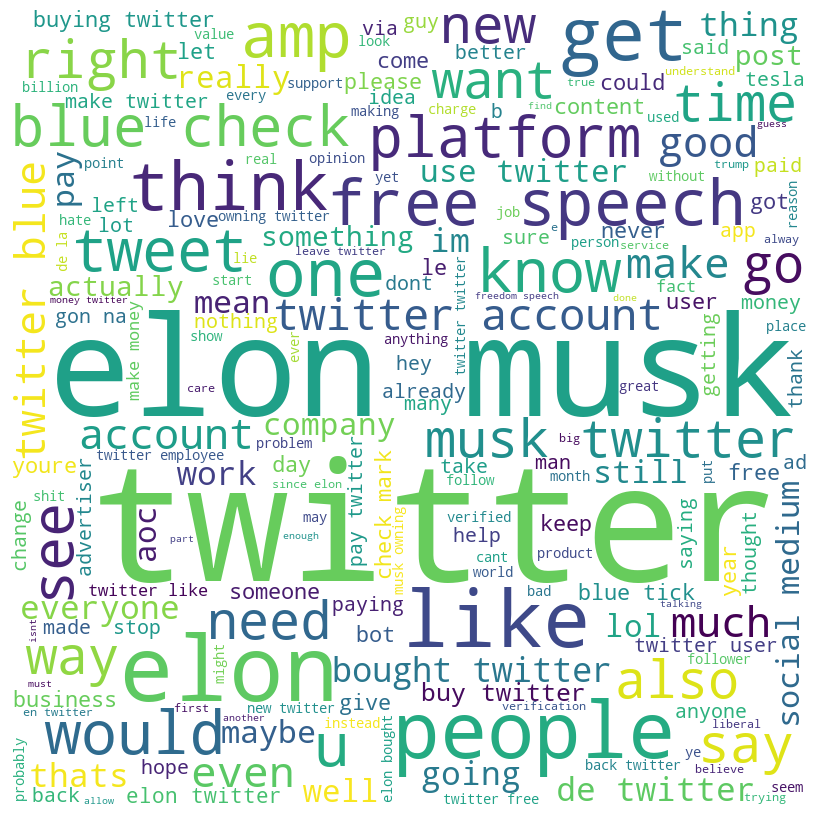

In [11]:
comment_words = ''

for val in df.processed_tweet:
     
    # typecaste each val to string
    val = str(val)
 
    # split the value
    tokens = val.split()
     
    comment_words += " ".join(tokens)+" "
 
wordcloud = WordCloud(width = 800, height = 800,background_color ='white',stopwords = stop_words,min_font_size = 10).generate(comment_words)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

In [12]:
df['day'] = df['Date'].dt.date
df['hour'] = df['Date'].dt.hour
df['hour'].head(2)

0    23
1    23
Name: hour, dtype: int64

In [13]:
new_df = df.groupby(['day','hour','Sentiment']).size().reset_index(name='counts')
new_df = pd.DataFrame(new_df)

new_df.head(3)

,day,hour,Sentiment,counts
0,2022-11-03,14,Negative,512
1,2022-11-03,14,Neutral,1074
2,2022-11-03,14,Positive,1211


In [14]:
new_df['Sentiment'] = new_df['Sentiment'].astype(str)
new_df['day']=pd.to_datetime(new_df['day'])

In [15]:
neg_df = pd.DataFrame(new_df.loc[new_df['Sentiment']=="Negative"])
pos_df = pd.DataFrame(new_df.loc[new_df['Sentiment']=="Positive"])

Text(0, 0.5, 'Count')

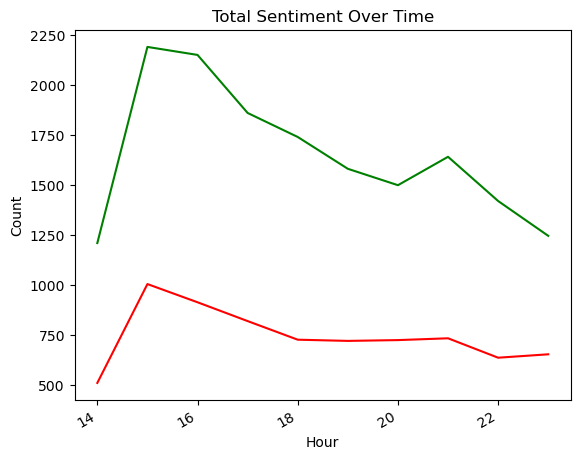

In [21]:

plt.plot(neg_df.hour,neg_df.counts, color="red")
plt.plot(pos_df.hour,pos_df.counts, color="green")
# Giving title to the graph
plt.title('Total Sentiment Over Time')
 
# rotating the x-axis tick labels at 30degree
# towards right
plt.xticks(rotation=30, ha='right')
 
# Giving x and y label to the graph
plt.xlabel('Hour')
plt.ylabel('Count')